# Reinforcement Learning

![](https://i.imgur.com/LIju2qJ.png)>


Reinforcement. Learning. Both words we've heard before. But together, what do these words mean? These are great questions. Let's talk about them together. Today, we're going to be discussing:

- What is reinforcement learning?
- How can we make a simple RL modts in Python?
- How does RL apply to neuro?

This tutorial is adapted from [Raphael's prior tutorial with R](https://dibsmethodsmeetings.github.io/RL-Guide/), and draws on [this great book that you should absolutely read if you're interested in RL](http://incompleteideas.net/book/the-book-2nd.html)!

# What is RL?

At its core, RL is about how we learn from rewards (and lack of rewards/punishment). We interact with our environment; certain things in our environment give us rewards, and performing certain actions lets us get those rewards. RL is a framework for how we learn about those rewards in our environment and adapt our actions to let us get more rewards. This is all very vague, but some specific examples are:

1. Classical conditioning
   A guy named Pavlov trained his dogs to associate the sound of a bell with food (since he would ring a bell, then feed his dogs). They started salivating in response to the bell! This is an example of **learning about rewards in our environment**; the dogs were learning that the bell was a signifier of reward.

2. Bandit problems
   A bandit problem is where someone is presented with a lever, and they're given the chance to pull the lever or not pull the lever. You have some probability of getting a reward when you pull the lever, and in some setups pulling the lever has some cost. People have to learn whether pulling the lever will be rewarding (on average), and need to choose whether or not to pull the lever. This comes from gambling (a slot machine is a one-armed bandit). People have extended this problem to multi-arm bandits. Instead of just one lever, there are 'k' arms that all give different rewards. People have to learn the rewards, then choose which levers to pull to maximize their rewards.

Fun fact about bandit problems: lots of psychology problems are framed in this way. We present subjects with stimuli that they have to learn to associate with rewards, they learn to maximize rewards, we change the reward distribution, and play that whole game all over again.

We're going to be coding up and simulating a bandit problem today! A 2-arm bandit. Fun fact is that this type of model can be used to make predictions about how people will learn and make choices in decision-making problems. With that being said, let's dive right in.

# How do we make a simple RL model in Python?

Reinforcement learning in general is hard. Luckily, we've simplified our job by giving our environment only two 'states', or things that can happen: lever 1 can be pulled or lever 2 can be pulled. We can explicitly calculate the 'value' of being in each of these two states. To simplify this value calculation, let's say that they each give the same reward (1 unit of reward), and lever 1 has a 70% chance of giving a reward while Arm 2 has a 30% chance of giving a reward. Our model's job is to learn these values. We'll be using numpy and base python to fit our model, and matplotlib to visualize the results!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

In [2]:
nArms = 2
armProbs = [0.7,0.3]
armRewards = [1,1]

## Q-Values

In RL-speak, the **Q-Value** is
our model's representation of the value of each state. We can essentially just make a little table with one entry for each state, and pop the estimated value of that state into the table. This doesn't work anymore as the number of things that can happen get really big (like in the real world), but will be perfect for us because only two things will happen! We will initialize our Q-values to 0.5, indicating that before doing anything, we think both levers are equally valuable. 

## Policies

Now that we have a representation of the world, we need to interact with the world. The way our model chooses to interact with the world is called the model's **policy**. In state-of-the-art machine learning, our models learn their policies too, but here we have to pick a policy. Policies are typically thought of as *greedy* or not. A greedy policy leans towards picking an action corresponding to the highest Q value, while a less greedy policy will more often sample across all actions.

**What would the issue be with always picking the action with the highest Q value?**

We're going to compare between two policies: an $\epsilon$-greedy policy and a softmax policy. An $\epsilon$-greedy policy selects the best action with probability $1 - \epsilon$, and uniformly selects an action with probability $\epsilon$. A softmax policy uses the softmax function to turn Q values into probabilities, then samples an action based on those probabilities. It requires a parameter called $\beta$, and a larger $\beta$ corresponds to a greedier policy. Let's code these both up here, with $\epsilon = 0.1$, $\beta = 4$. Since the Q values are equal at the beginning, we'll randomly pick the first epsilon-greedy model action too.

In [3]:
epsilon = 0.1
beta = 4
actions = [0,1]
epsilonQs = np.array([0.5,0.5])
softmaxQs = np.array([0.5,0.5])
softmaxProbs = np.exp(beta * softmaxQs)/np.sum(np.exp(beta * softmaxQs))
epsilonAction = np.random.choice(actions,1,p=epsilonQs)[0]
softmaxAction = np.random.choice(actions,1,p=softmaxProbs)[0]

print(f"Epsilon model picked lever {epsilonAction + 1}")
print(f"Softmax model picked lever {softmaxAction + 1}")

Epsilon model picked lever 2
Softmax model picked lever 1


## Sampling rewards and updating Q values

Now that our models have each chosen an action, let's get them their rewards! Our rewards are probabilistic, so we need do some more sampling.
To actually UPDATE our Q-values, we need to learn from our mistakes. Our error is just going to be the actual reward that we got (1 or 0 here) minus our predicted value of the state (the current Q-value). To stabilize learning in our model, we're going to downweight that prediction error a little bit (by a learning rate $\alpha$): this is a typical trick in machine learning to make sure no single error changes the model too much. We'll set ours to 0.1 here.

In [4]:
alpha=0.1
epsilonReward =  armRewards[epsilonAction]*np.random.binomial(1,armProbs[epsilonAction])
softmaxReward = armRewards[softmaxAction]*np.random.binomial(1,armProbs[softmaxAction])

print(f"Epsilon model got a reward of: {epsilonReward}")
print(f"Softmax model got a reward of: {softmaxReward}")

epsilonError = epsilonReward - epsilonQs[epsilonAction]
softmaxError = softmaxReward - softmaxQs[softmaxAction]

print(f"Our epsilon model's error: {epsilonError}")
print(f"Our softmax model's error: {softmaxError}")

epsilonQs[epsilonAction] = epsilonQs[epsilonAction] + alpha*epsilonError
softmaxQs[softmaxAction] = softmaxQs[softmaxAction] + alpha*softmaxError

print(f"New epsilon model Qs: {epsilonQs}")
print(f"New softmax models Qs: {softmaxQs}")

Epsilon model got a reward of: 1
Softmax model got a reward of: 0
Our epsilon model's error: 0.5
Our softmax model's error: -0.5
New epsilon model Qs: [0.5  0.55]
New softmax models Qs: [0.45 0.5 ]


## Rinse and repeat

We then continue this process of sampling and updating our Q values until everything stabilizes! Since our environmnent isn't changing, our estimates WILL stabilize. Let's make each of these into a class so that we can train our models more easily, then train them for a few iterations!

In [5]:
from abc import ABC,abstractmethod
class BanditModel(ABC):

    def __init__(self,alpha,n_actions=2):

        self.alpha = alpha
        self.Qs = np.ones((n_actions,))/n_actions

    @abstractmethod
    def pickAction(self):

        return NotImplemented

    def calculateError(self,action,reward):

        error = reward - self.Qs[action]
        return error

    def updateQs(self,action,reward):

        error = self.calculateError(action,reward)

        self.Qs[action] += self.alpha*error

class epsilonGreedyModel(BanditModel):

    def __init__(self,epsilon,alpha,n_actions=2):

        super(epsilonGreedyModel,self).__init__(alpha,n_actions)
        self.epsilon=epsilon

    def pickAction(self):

        sample = np.random.uniform(0,1)
        if sample < epsilon:
            action = np.random.choice(len(self.Qs),1,p=np.ones((len(self.Qs),))/len(self.Qs))[0]
        else:
            action = np.argmax(self.Qs)

        return action

class softmaxModel(BanditModel):

    def __init__(self,beta,alpha,n_actions=2):

        super(softmaxModel,self).__init__(alpha,n_actions)
        self.beta=beta

    def pickAction(self):

        softmaxProbs = np.exp(beta * self.Qs)/np.sum(np.exp(beta * self.Qs))

        action = np.random.choice(len(self.Qs),1,p=softmaxProbs)[0]

        return action

class bandit():

    def __init__(self,rewardProbs,rewards):

        self.rewardProbs = rewardProbs
        self.rewards = rewards

    def sampleReward(self,action):

        return self.rewards[action]*np.random.binomial(1,self.rewardProbs[action])

In [6]:
model1 = epsilonGreedyModel(epsilon=0.1,alpha=0.1,n_actions=2)
model2 = softmaxModel(beta=4,alpha=0.1,n_actions=2)
bandit1 = bandit(rewardProbs=[0.7,0.3],rewards=[1,1])

In [7]:

for ii in range(5):

    model1Action = model1.pickAction()
    model2Action = model2.pickAction()

    model1Reward = bandit1.sampleReward(model1Action)
    model2Reward = bandit1.sampleReward(model2Action)

    print(f"Epsilon Greedy Qs before updating: {model1.Qs}")
    model1.updateQs(model1Action,model1Reward)
    print(f"Epsilon Greedy Qs after updating: {model1.Qs}")

    print(f"Softmax Qs before updating: {model2.Qs}")
    model2.updateQs(model2Action,model2Reward)
    print(f"Softmax Qs after updating: {model2.Qs}")

Epsilon Greedy Qs before updating: [0.5 0.5]
Epsilon Greedy Qs after updating: [0.55 0.5 ]
Softmax Qs before updating: [0.5 0.5]
Softmax Qs after updating: [0.5  0.55]
Epsilon Greedy Qs before updating: [0.55 0.5 ]
Epsilon Greedy Qs after updating: [0.595 0.5  ]
Softmax Qs before updating: [0.5  0.55]
Softmax Qs after updating: [0.5   0.495]
Epsilon Greedy Qs before updating: [0.595 0.5  ]
Epsilon Greedy Qs after updating: [0.6355 0.5   ]
Softmax Qs before updating: [0.5   0.495]
Softmax Qs after updating: [0.5    0.4455]
Epsilon Greedy Qs before updating: [0.6355 0.5   ]
Epsilon Greedy Qs after updating: [0.67195 0.5    ]
Softmax Qs before updating: [0.5    0.4455]
Softmax Qs after updating: [0.55   0.4455]
Epsilon Greedy Qs before updating: [0.67195 0.5    ]
Epsilon Greedy Qs after updating: [0.704755 0.5     ]
Softmax Qs before updating: [0.55   0.4455]
Softmax Qs after updating: [0.595  0.4455]


As you can see, our Q values are updating each trial! Let's run a whole process to see how Q values look across time.

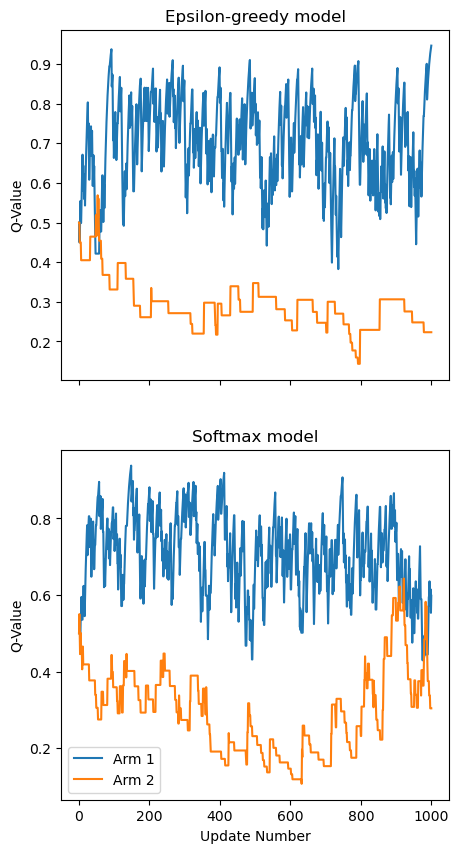

In [8]:
%matplotlib inline
nUpdates = 1000

model1 = epsilonGreedyModel(epsilon=0.1,alpha=0.1,n_actions=2)
model2 = softmaxModel(beta=5,alpha=0.1,n_actions=2)
bandit1 = bandit(rewardProbs=[0.7,0.3],rewards=[1,1])

model1Qs = []
model2Qs = []
model1Qs.append(copy.deepcopy(model1.Qs))
model2Qs.append(copy.deepcopy(model2.Qs))

for ii in range(nUpdates):

    model1Action = model1.pickAction()
    model2Action = model2.pickAction()

    model1Reward = bandit1.sampleReward(model1Action)
    model2Reward = bandit1.sampleReward(model2Action)

    model1.updateQs(model1Action,model1Reward)
    model2.updateQs(model2Action,model2Reward)
    model1Qs.append(copy.deepcopy(model1.Qs))
    model2Qs.append(copy.deepcopy(model2.Qs))
    



fig,axs= plt.subplots(nrows=2,ncols=1,figsize=(5,10),sharex=True)
x = np.arange(0,nUpdates + 1)
model1Qs = np.array(model1Qs)
model2Qs = np.array(model2Qs)

for ii in range(model1Qs.shape[1]):
    axs[0].plot(x,model1Qs[:,ii],label=f"Arm {ii+1}")
axs[0].set_ylabel("Q-Value")
axs[0].set_title("Epsilon-greedy model")
for ii in range(model2Qs.shape[1]):
    axs[1].plot(x,model2Qs[:,ii],label=f"Arm {ii+1}")
axs[1].set_ylabel("Q-Value")
axs[1].set_xlabel("Update Number")
axs[1].set_title("Softmax model")
plt.legend()
plt.show()
plt.close()



Great! So it seems like both of these models get close to the right Q value for each of the arms! But how do they perform in terms of the rewards that they get? To find this out, let's average the reward collected over a bunch of different model fits.

Fitting different models: 100%|█████████████████████████████████| 1000/1000 [01:19<00:00, 12.54it/s]


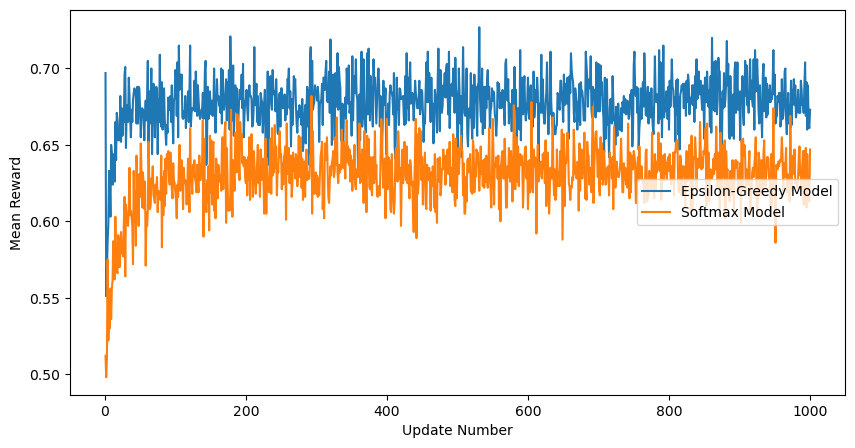

In [11]:
%matplotlib inline

nUpdates = 1000


nFits = 1000

rewards1 = []
rewards2 = []

for jj in tqdm(range(nFits), desc="Fitting different models"):
    model1 = epsilonGreedyModel(epsilon=0.1,alpha=0.1,n_actions=2)
    model2 = softmaxModel(beta=5,alpha=0.1,n_actions=2)
    bandit1 = bandit(rewardProbs=[0.7,0.3],rewards=[1,1])

    tmpRewards1 = []
    tmpRewards2 = []
    
    for ii in range(nUpdates):
    
        model1Action = model1.pickAction()
        model2Action = model2.pickAction()
    
        model1Reward = bandit1.sampleReward(model1Action)
        model2Reward = bandit1.sampleReward(model2Action)
    
        model1.updateQs(model1Action,model1Reward)
        model2.updateQs(model2Action,model2Reward)
        tmpRewards1.append(model1Reward)
        tmpRewards2.append(model2Reward)

    rewards1.append(np.array(tmpRewards1))
    rewards2.append(np.array(tmpRewards2))
        



fig,ax= plt.subplots(nrows=1,ncols=1,figsize=(10,5))
x = np.arange(1,nUpdates + 1)
meanRewards1 = np.nanmean(np.array(rewards1),axis=0)
meanRewards2 = np.nanmean(np.array(rewards2),axis=0)
ax.plot(x,meanRewards1,label="Epsilon-Greedy Model")
ax.plot(x,meanRewards2,label="Softmax Model")
ax.set_ylabel("Mean Reward")
ax.set_xlabel("Update Number")
plt.legend(loc='right')
plt.show()
plt.close()

There you have it! We now have bandit models and good ways to compare them. Let's do some of this ourselves!

1. How do these models perform when we change $\epsilon$? What about $\beta$?
2. What happens if we add in more arms? What if we change how rewarding each arm is?
3. What happens if we turn the reward for each arm into a distribution of rewards instead of a deterministic value?

# How does any of this relate to neuro & psych?

Well, people go to casinos all the time, so there's that.
In a much more real sense, we're faced with choices with unknown outcomes all the time, and we have to 1. make decisions based on our expectations of the outcomes, then 2. learn from the outcomes of our decisions. One of the early (but also foundational) models of this is the [Rescorla-Wagner model](https://en.wikipedia.org/wiki/Rescorla–Wagner_model#:~:text=The%20Rescorla–Wagner%20model%20(",and%20unconditioned%20(US)%20stimuli.), which posits that animals only learn when events violate their expectations (or when their predictions are off). Their model was meant to account for blocking: the phenomenon where if an animal learns a relationship between a stimulus and a reward, that learned relationship *blocks* it from learning a relationship between any new stimuli presented alongside the stimuli with the learned relationships. The learning here is very similar to that in the bandit problem; the model updates its internal state values through a scaled prediction error.

This kind of psychological process is mirrored in the activity of dopamine (DA) neurons as well! The classic Wolfram Shultz experiments detailed how DA neurons phasically adjust their firing rates based not just on reward, but on the difference between the received reward and expected reward. Much of the work in psych and neuro on learning has been built off of this concept. The errors in this model are specifically **Temporal-Difference (TD) Errors**: prediction errors in the model are assigned to stimuli nearby in time. There are more details there, but we don't have enough time to cover them here.